## Dataset annotation estraction 2

### Mask R-CNN dataset input format

#### In this project each object contained into one image must be passed to the training algorithm as an image in grey scale (one value for each pixel) where only one instance should be present in each mask, obviusly there may be more than one mask for each image, each mask should be associated with their class.


### Parsing of Supervisely dataset with annotations in json format

#### This notebook shows how to convert the json files in the supervisely dataset into the format required as input by the training program. In this notebook in detail is shown how to extract each instance(*) as a separate mask, following this steps:
- Import the image and its mask
- Separate the mask based on the class, obtaining one mask from each class present in the original mask.
- How to use the function cv2.connectedComponentsWithStats() for the separation of the istances of the same class.
- In the last part is shown how to pack this masks into one dict and group theme by class.
- The result of this job was printed into groups of plots relative to the same class.

#### NOTE: This notebook is only demonstrative, to explain how the separation of the instace into the masks is possible, but the dataset in this form isn't the best choice for Mask R-CNN. it is limeted beacause in the same pixel can't coexist more than one class, while Mask R-CNN can generate overlapped instance. For example take the disk in this example, it would have been better if the mask of the disk class had been intact, but as it is possible to see the presence of the instances of the other classes over the disk generate holes which can influence the effectiveness of the training of Mask R-CNN with this dataset, so this type of dataset is good for semantic segmentation but it's not so good for istance segmentation.

#### in the next notebook will be shown how to prepare the dataset starting from the json format of supervisely that is the better choise for training an instance segmentation model. 

*istance: object belonging at one class logicaly separable from other objects of the same class.

### Parsing of Supervisely dataset with annotations in json  format

#### 

In [12]:
# import libraries
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import imutils
import base64
import zlib
import math
import json
import cv2
import os
import io

In [13]:
# definiscions of images path and annotation json files 
img_1_path = 'sample_imgs/cast_def_0_102.jpeg'
img_2_path = 'sample_imgs/cast_def_0_1427.jpeg'

ann_1_path = 'sample_annotations/cast_def_0_102.jpeg.json'
ann_2_path = 'sample_annotations/cast_def_0_1427.jpeg.json'

text_settings = {
    'fontsize':22,
    'fontweight':10
}

image shape: (512, 512, 3)


<Figure size 432x288 with 0 Axes>

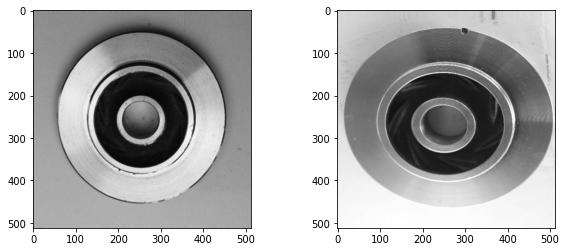

In [14]:
#reading the images
# loading images from their folders
img1 = cv2.imread(img_1_path)
img2 = cv2.imread(img_2_path)
print(f'image shape: {img1.shape}')

#----------------------------------------------------------------------------------------------------------
# plot functions ------------------------------------------------------------------------------------------
# note that the last image is augmented by matplotlib to make classes distingushable
plt.figure()
f, window = plt.subplots(1,2,figsize=(10,4)) 
window[0].imshow(img1)
window[1].imshow(img2)


In [15]:
# loading annotation files
with open (ann_1_path, "r") as jsonFile1:
    jsonString1 = jsonFile1.read()

with open (ann_2_path, "r") as jsonFile2:
    jsonString2 = jsonFile2.read()

ann1 = json.loads(jsonString1)
ann2 = json.loads(jsonString2)

#printing the json
print(json.dumps(ann1, indent = 2))

{
  "description": "",
  "tags": [
    {
      "id": 105626860,
      "tagId": 29138031,
      "name": "bad",
      "value": null,
      "labelerLogin": "max_svm",
      "createdAt": "2021-05-12T08:50:31.083Z",
      "updatedAt": "2021-05-12T08:50:31.083Z"
    }
  ],
  "size": {
    "height": 512,
    "width": 512
  },
  "objects": [
    {
      "id": 731743712,
      "classId": 2926797,
      "description": "",
      "geometryType": "bitmap",
      "labelerLogin": "max_svm",
      "createdAt": "2021-05-12T08:53:14.856Z",
      "updatedAt": "2021-05-15T17:03:22.089Z",
      "tags": [],
      "classTitle": "disk",
      "bitmap": {
        "data": "eJwBsgRN+4lQTkcNChoKAAAADUlIRFIAAAGIAAABkQEDAAAARVS2NgAAAAZQTFRFAAAA////pdmf3QAAAAF0Uk5TAEDm2GYAAARaSURBVHic7dxNjpwwEAXgjrKYpZUT+Cg+mjkaR+EILFmgdpJJM+Cfcr1XI1Ar3WxHn3D5lYnSYN9uzetXSmv7L8IV0p/rzoKUFhj8SI9rYkFKoPC7AKtPhwsalz8K6CYpuwYdfOQCuElI5E1+FkCvvbyF3iuxFNqwqkGpw/K1UPqxHpRSyI8apDT2hGuJmRyUMqwW6M5vY27/XhNZRrcbfVt0CgltIRfSTOPvNdNCLEQovFOIVIb8

In [16]:
# defining supervisely functions

def base64_2_mask(s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)
    #n = np.fromstring(z, np.uint8) #depecated
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    return mask

def mask_2_base64(mask):
    img_pil = Image.fromarray(np.array(mask, dtype=np.uint8))
    img_pil.putpalette([0,0,0,255,255,255])
    bytes_io = io.BytesIO()
    img_pil.save(bytes_io, format='PNG', transparency=0, optimize=0)
    bytes = bytes_io.getvalue()
    return base64.b64encode(zlib.compress(bytes)).decode('utf-8')

In [17]:
# Dummy example of encoding and decoding

example_np_bool = np.ones((3, 3), dtype=bool)
example_np_bool[1][1] = False
example_np_bool[1][2] = False
print(example_np_bool)
encoded_string = mask_2_base64(example_np_bool)
print(encoded_string)
print(base64_2_mask(encoded_string))

[[ True  True  True]
 [ True False False]
 [ True  True  True]]
eJzrDPBz5+WS4mJgYOD19HAJAtLMIMwIInOeqf8BUmwBPiGuQPr///9Lb86/C2QxlgT5BTM4PLuRBuTwebo4hlTMSa44cOHAB6DqY0yORgq8YkAZBk9XP5d1TglNANAFGzA=
[[ True  True  True]
 [ True False False]
 [ True  True  True]]


<Figure size 432x288 with 0 Axes>

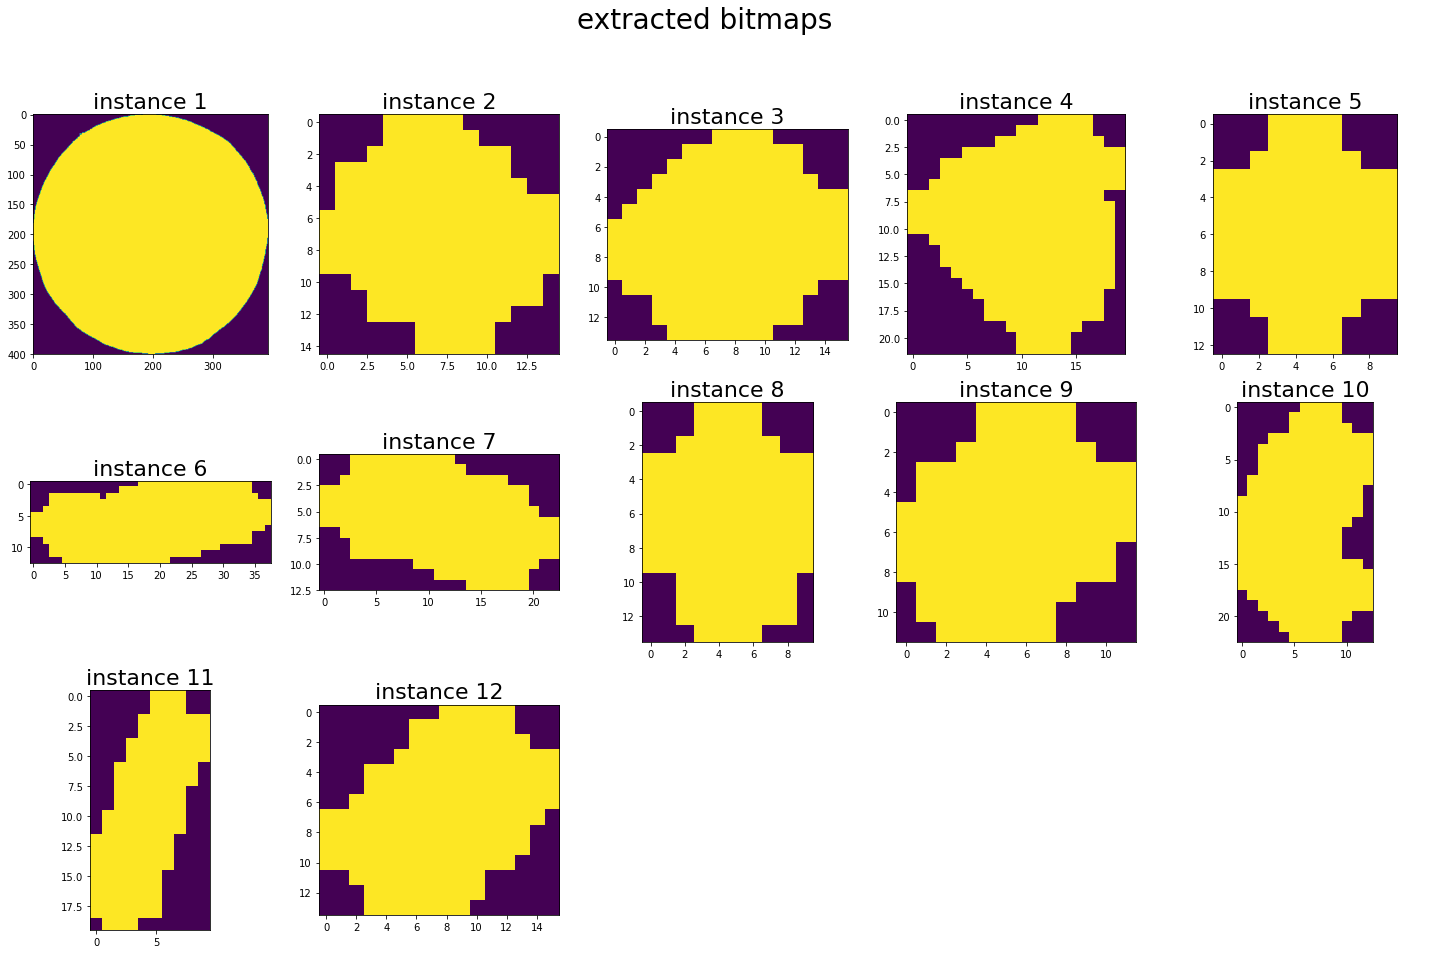

In [18]:
img_dims = [ann1['size']['height'], ann1['size']['width']]
objects = ann1['objects']

class_conv = {
  "chipping":   1,
  "deburring":  2,
  "holes":      3,
  "disk":       4
}

bitmaps = []
origins = []
class_  = []
class_idxs = []

n_obj = len(objects)

for i in range(n_obj):
    bitmaps.append(base64_2_mask(objects[i]['bitmap']['data']))
    origins.append(objects[i]['bitmap']['origin'])
    class_.append(objects[i]['classTitle'])

    for obj_class in class_conv.keys():
        if obj_class == class_[i]:
            class_idxs.append(class_conv[obj_class])

#----------------------------------------------------------------------------------------------------------
# plot functions ------------------------------------------------------------------------------------------
max_n_cols = 5
cols = max_n_cols if n_obj >= max_n_cols else n_obj
rows = math.ceil(n_obj/cols)

#print(f'rows:{rows}, cols:{cols}')

plt.figure()
f, window = plt.subplots(rows, cols,figsize=(cols*5,rows*5)) 
f.patch.set_facecolor('#FFFFFF')

f.suptitle("extracted bitmaps", fontsize=28)

for row in range(rows):
    for col in range(cols):
        j = row*cols + col
        if j < n_obj:
            if rows > 1:
                window[row][col].imshow(bitmaps[j])
                window[row][col].set_title(f'instance {j+1}', fontdict = text_settings)
            elif cols > 1:
                window[col].imshow(bitmaps[j])
                window[col].set_title(f'instance {j+1}', fontdict = text_settings) 
            else:
                window.imshow(bitmaps[j])
                window.set_title(f'instance {j+1}', fontdict = text_settings) 
        else:
            if rows > 1:
                window[row][col].axis('off')
            elif cols > 1:
                window[col].axis('off')
            else:
                window.axis('off')

In [19]:
# dummy example on how to broadcast one small array
# on top of another

base = np.zeros((5, 5), dtype="uint8")
sup = np.ones((2, 2), dtype="uint8")
print(base)
print(sup)

base[2:4, 0:2] = sup
print(base)

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[1 1]
 [1 1]]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [1 1 0 0 0]
 [1 1 0 0 0]
 [0 0 0 0 0]]


instance: 0, ox:54, oy:60, w:401, h:392
instance: 1, ox:369, oy:197, w:15, h:15
instance: 2, ox:379, oy:230, w:14, h:16
instance: 3, ox:264, oy:361, w:22, h:20
instance: 4, ox:269, oy:443, w:13, h:10
instance: 5, ox:443, oy:259, w:13, h:38
instance: 6, ox:439, oy:201, w:13, h:23
instance: 7, ox:201, oy:256, w:14, h:10
instance: 8, ox:274, oy:201, w:12, h:12
instance: 9, ox:297, oy:262, w:23, h:13
instance: 10, ox:214, oy:213, w:20, h:10
instance: 11, ox:143, oy:297, w:14, h:16
(512, 512, 12)
bool


<Figure size 432x288 with 0 Axes>

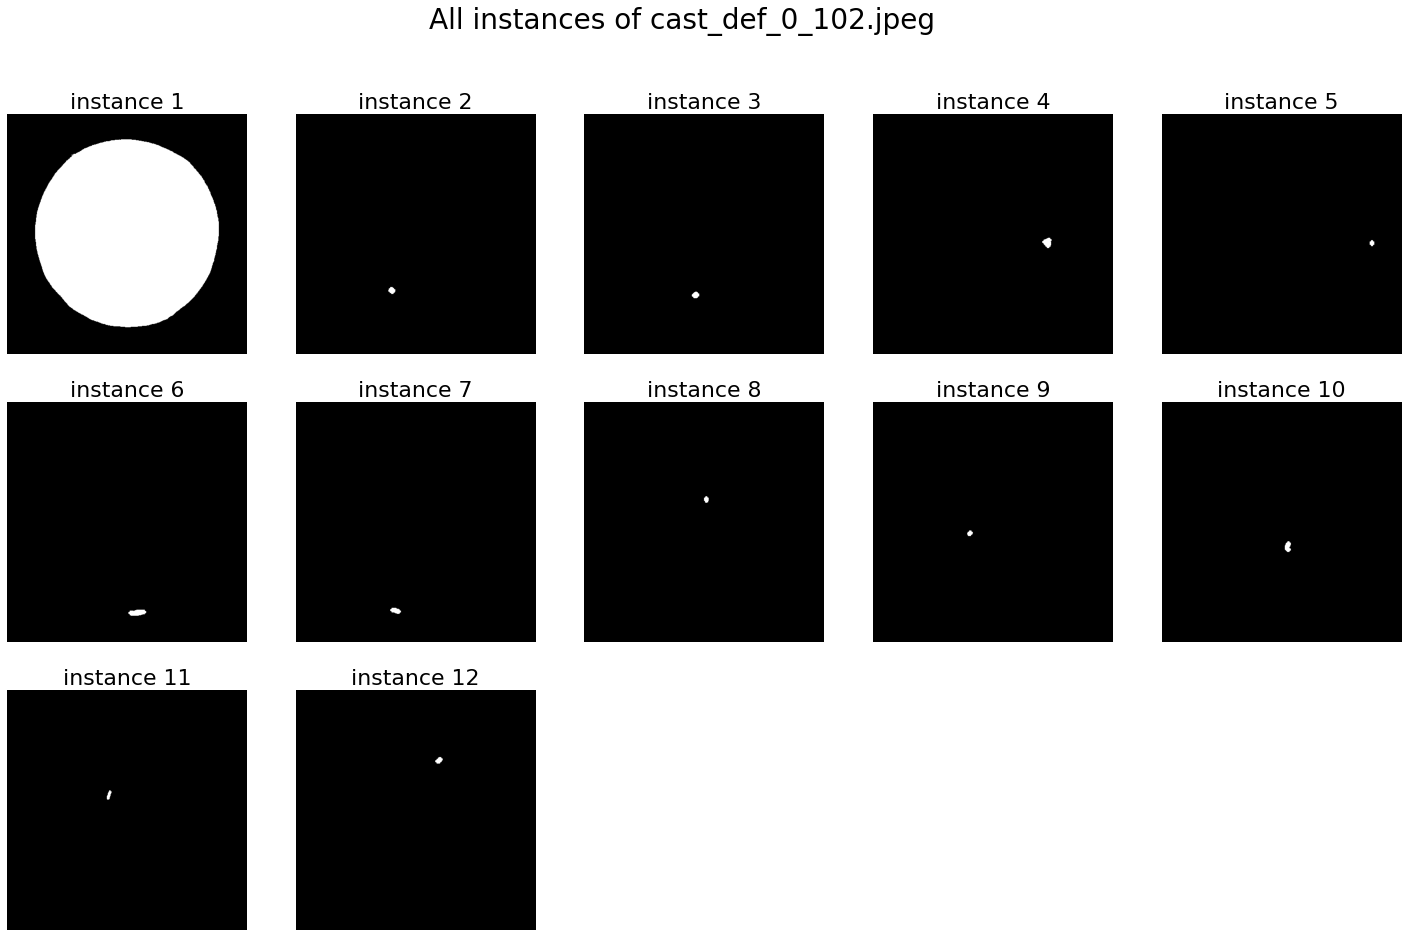

<Figure size 432x288 with 0 Axes>

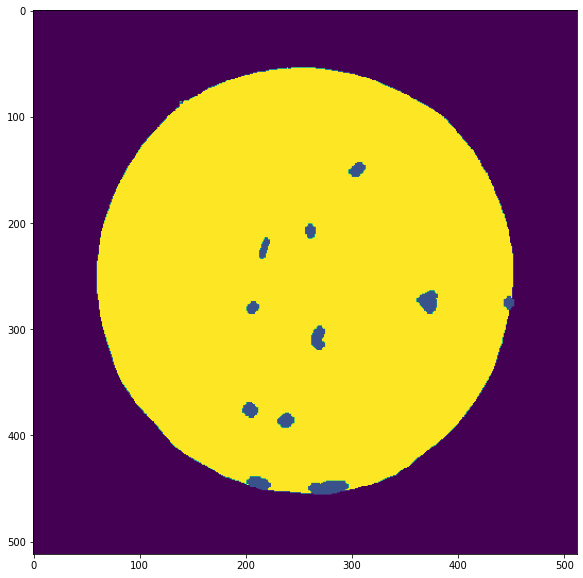

In [20]:
# Now each bittmap should be placed into the right place into the mask with the right scale

# the first ting to do is to create a black numpy matrix 
# that can contain each bitmap in the right place
masks = np.zeros((img_dims[0], img_dims[1], n_obj), dtype="bool")
mask_test = np.zeros((img_dims[0], img_dims[1]), dtype="uint8")

for i in range(n_obj):
    ox = origins[i][1]
    oy = origins[i][0]
    w = bitmaps[i].shape[0]
    h = bitmaps[i].shape[1]
    print(f'instance: {i}, ox:{ox}, oy:{oy}, w:{w}, h:{h}')
    masks[ox:ox+w, oy:oy+h, i] = bitmaps[i]

    # reconstruction of the original image as proof
    mask_test[masks[:, :, i]] = class_idxs[i]

print(masks.shape)
print(masks.dtype)

#----------------------------------------------------------------------------------------------------------
# plot functions ------------------------------------------------------------------------------------------
max_n_cols = 5
cols = max_n_cols if n_obj >= max_n_cols else n_obj
rows = math.ceil(n_obj/cols)

#print(f'rows:{rows}, cols:{cols}')

plt.figure()
f, window = plt.subplots(rows, cols,figsize=(cols*5,rows*5)) 
f.patch.set_facecolor('#FFFFFF')

f.suptitle("All instances of cast_def_0_102.jpeg", fontsize=28)

for row in range(rows):
    for col in range(cols):
        j = row*cols + col
        if j < n_obj:
            if rows > 1:
                window[row][col].imshow(masks[:,:,j], cmap='gray')
                window[row][col].set_title(f'instance {j+1}', fontdict = text_settings)
            elif cols > 1:
                window[col].imshow(masks[:,:,j], cmap='gray')
                window[col].set_title(f'instance {j+1}', fontdict = text_settings) 
            else:
                window.imshow(masks[:,:,j], cmap='gray')
                window.set_title(f'instance {j+1}', fontdict = text_settings) 

        if rows > 1:
            window[row][col].axis('off')
        elif cols > 1:
            window[col].axis('off')
        else:
            window.axis('off')

plt.figure()
f, window = plt.subplots(1, 1,figsize=(10,10)) 
window.imshow(mask_test)